In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
raw = pd.read_csv('Data/kospi.csv', encoding = 'cp949')

# 전처리

In [7]:
raw.head()

,일자,현재지수,대비,등락률(%),배당수익률(%),주가이익비율,주가자산비율,시가지수,고가지수,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원)
0,1980/01/04,100.00,NaN,-,0.0,0.0,0.0,NaN,NaN,NaN,96,603,NaN
1,1980/01/05,100.15,NaN,-,0.0,0.0,0.0,NaN,NaN,NaN,131,776,NaN
2,1980/01/07,102.53,NaN,-,0.0,0.0,0.0,NaN,NaN,NaN,358,"2,030",NaN
3,1980/01/08,105.28,NaN,-,0.0,0.0,0.0,NaN,NaN,NaN,796,"5,567",NaN
4,1980/01/09,106.37,NaN,-,0.0,0.0,0.0,NaN,NaN,NaN,552,"3,706",NaN


In [8]:
raw.dtypes

일자              object
현재지수            object
대비             float64
등락률(%)          object
배당수익률(%)       float64
주가이익비율         float64
주가자산비율         float64
시가지수            object
고가지수            object
저가지수            object
거래량(천주)         object
거래대금(백만원)       object
상장시가총액(백만원)     object
dtype: object

In [9]:
raw['일자'] = raw['일자'].apply(lambda x: x.replace('/','')).astype('int')
raw['현재지수'] = raw['현재지수'].apply(lambda x: x.replace(',','')).astype('float')
raw['등락률(%)'] = raw['현재지수'].pct_change().fillna(0) +1

raw = raw[['일자','현재지수','등락률(%)']]

In [10]:
raw.head()

,일자,현재지수,등락률(%)
0,19800104,100.00,1.000000
1,19800105,100.15,1.001500
2,19800107,102.53,1.023764
3,19800108,105.28,1.026821
4,19800109,106.37,1.010353


In [11]:
raw['GIJUN_MONTH'] = raw['일자'].apply(lambda x: x//100)

In [12]:
raw.tail()

,일자,현재지수,등락률(%),GIJUN_MONTH
10411,20180813,2248.45,0.984957,201808
10412,20180814,2258.91,1.004652,201808
10413,20180816,2240.80,0.991983,201808
10414,20180817,2247.05,1.002789,201808
10415,20180820,2247.88,1.000369,201808


# MCS를위한 기초 data 생성

In [13]:
column_list = ['GIJUN_MONTH','SILH_SUIK_RT','KOSPI(월초)','KOSPI(월말)']

store_dict = {'GIJUN_MONTH' : [],
              'SILH_SUIK_RT' : [],
              'KOSPI(월초)' : [],
              'KOSPI(월말)' : []}
# 월초
jisu1_list = []

#월말
jisu2_list = []

month_list = []
suik_list = []

for month in raw['GIJUN_MONTH'].unique():
    temp = raw[raw['GIJUN_MONTH'] == month]
    
    # 2018년 8월 자료는 제외
    if month == 201808: continue
    
    # 월 기록
    store_dict['GIJUN_MONTH'].append(month)
    
    # 월초 주가 기록
    store_dict['KOSPI(월초)'].append(temp['현재지수'].iloc[0])
    
    # 월말 주가 기록
    store_dict['KOSPI(월말)'].append(temp['현재지수'].iloc[-1])
    
    # 월 수익률 기록
    store_dict['SILH_SUIK_RT'].append(np.prod(temp['등락률(%)']))
    
data = pd.DataFrame(store_dict)

In [14]:
data.head()

,GIJUN_MONTH,SILH_SUIK_RT,KOSPI(월초),KOSPI(월말)
0,198001,1.058900,100.00,105.89
1,198002,0.979696,104.48,103.74
2,198003,1.012146,103.96,105.00
3,198004,1.105619,105.43,116.09
4,198005,1.002929,116.54,116.43


In [15]:
#randomly pick without replacement
random_index = np.random.choice(data.index, 6)
data.loc[random_index]

,GIJUN_MONTH,SILH_SUIK_RT,KOSPI(월초),KOSPI(월말)
308,200509,1.127090,1106.37,1221.01
189,199510,1.007744,975.79,990.26
99,198804,0.985849,654.32,647.18
275,200212,0.865825,730.16,627.55
207,199704,1.038223,672.99,703.23
358,200911,0.984127,1559.09,1555.60


In [25]:
from collections import OrderedDict
from sympy import Symbol, solve


def boostrapping_main_func(n_period, n_iter):
    # 매월 10000원씩, n_period의 기간만큼 투자하였다고 가정,
    investment = 10000
    total_investment = n_period * investment

    # 무위험 수익률은 년 3%로 계산
    rf_annual = 0.03
    rf_monthly = np.power(1+rf_annual, 1/12) -1

    store_dict = OrderedDict(\
                             {
                              '전체 시나리오' : [],
                              '메인 시나리오' : [],
                              '세부 시나리오' : [],

                              'LS 수익률(%)' : [],
                              'BH 수익률(%)' : [],
                              'DCA1 수익률(%)' : [],
                              'DCA1* 수익률(%)' : [],

                              'P_0' : [],
                              'P_T' : [],
                              'H_DCA1' : [],
                              'H_DCA1*' : [],
                              })
    
    # 부스트래핑 n_iter번 반복
    for i in range(n_iter):


        if i % 500 == 0 : print('%s번 반복 완료'%i)
        
        #randomly pick without replacement
        random_index = np.random.choice(data.index, n_period)
        temp = data.loc[random_index]
        temp.index = np.arange(n_period) # temp의 인덱스를 초기화해준다.
        
        # 최초시점의 KOSPI를 1을 기준으로 한다.
        kospi_0 = 1

        # 중간시점 KOSPI를 기록한다.
        kospi_05 = np.prod(temp['SILH_SUIK_RT'].iloc[:n_period//2])

        # 마지막 시점 KOSPI 기록
        kospi_t = np.prod(temp['SILH_SUIK_RT'])

        # state : 각각의 시나리오 (ex: 상상)를 기록할 변수
        total_senario = '' # 매월마다 기록
        main_senario = ''  # 하나만 기록 (전체를 대표하는 하나의 값)
        sebu_senario = ''  # 

        ################ total_senario (전체 기간) 계산 ##################
        for index in temp.index:
            
            # t개월 까지의 자료를 가져온다.
            row = temp.loc[:index, :]

            # kospi_new : t월의 마지막 날 주가
            kospi_new = np.prod(row['SILH_SUIK_RT'])

            # t기간 수익률
            suik_t = kospi_new / kospi_0  # kospi_0 = 1

            ##### 상, 하 state 기록
            if suik_t >= 1:
                total_senario += '상'
            else:
                total_senario += '하'

        # total senario = xxxxxxxxxxxx (x : n_period)
        store_dict['전체 시나리오'].append(total_senario)

        
        
        ######################## 메인 시나리오 계산 ###########################

        up = 0
        down = 0
        
        # 월별로 상의 개수와 하의 개수를 센다.
        for letter in total_senario:
            if letter == '상':
                up += 1
            elif letter == '하':
                down += 1

        # 상의 비중이 절반 이상이면 '강', 절반 이하이면 '약'
        # 만약 상과 하의 수가 동일하다면, 
        # T시점의 지수가 0시점의 지수보다 높으면 '강', 낮으면 '하'
        if up > n_period/2 :
            main_senario += '강'

        elif down > n_period/2 :
            main_senario += '약'

        elif up == n_period/2 :
            if kospi_t >= kospi_0:
                main_senario += '강'

            elif kospi_t < kospi_0:
                main_senario += '약'

        store_dict['메인 시나리오'].append(main_senario)


        ############################ 세부 시나리오 계산 ############################
        # 전기 (최초 n_period/2 개월) 
        up = 0
        down = 0
        
        # 전기에, 상의 개수가 절반 이상이면 '강'
        for letter in total_senario[:n_period//2]:
            if letter == '상':
                up += 1
            elif letter == '하':
                down += 1          

        if up > n_period/4 :
            sebu_senario += '강'

        if down > n_period/4 :
            sebu_senario += '약'

        if up == n_period/4 :
            if kospi_05 >= kospi_0:
                sebu_senario += '강'

            elif kospi_05 < kospi_0:
                sebu_senario += '약'

        # 후기에, 상의 개수가 절반 이상이면 '강'
        up = 0
        down = 0

        for letter in total_senario[n_period//2:]:
            if letter == '상':
                up += 1
            elif letter == '하':
                down += 1          

        if up > n_period/4 :
            sebu_senario += '강'

        if down > n_period/4 :
            sebu_senario += '약'

        if up == n_period/4 :
            if kospi_t >= kospi_05:
                sebu_senario += '강'
            elif kospi_t < kospi_05:
                sebu_senario += '약'


        store_dict['세부 시나리오'].append(sebu_senario)

        
        ################### P_0 , P_T 계산 ###############################
        P_0 = 1  # 0시점 지수를 1로 가정
        P_T = temp['SILH_SUIK_RT'].prod() # T 시점 지수

        
        ###################### LS , BH 수익률 계산 ###################
        LS_HPR = P_T / P_0 -1 # HPR  0.1 = 10%로 표기
        LS_annual = np.power(LS_HPR +1 , 12/n_period) -1 # annualize, 0.1 = 10%의 %단위로 표기
        
        # 반은 주식, 반은 무위험자산에 투자
        # (0.5 * R_stock + 0.5 * R_free) / 1
        ## HPR  0.1 = 10% 꼴로 표기
        BH_HPR = 0.5*LS_HPR   + 0.5*(np.power(1+ rf_annual, 12/ n_period) -1) 
        BH_annual = np.power(BH_HPR +1, 12/n_period) -1

        store_dict['LS 수익률(%)'].append(round(LS_annual * 100,3))
        store_dict['BH 수익률(%)'].append(round(BH_annual * 100,3))


        ##################### DCA1 FV 계산 ########################
        FV_sum = 0

        for i in range(n_period):
            FV_sum += investment * np.prod(temp['SILH_SUIK_RT'].iloc[i:])

        # FV_sum : 적립식 투자안의 미래가치의 총합
        FV_sum = np.round(FV_sum,2)

        #################### DCA1 수익률 계산 ########################
        DCA1_HPR = FV_sum / total_investment -1 # HPR 0.1 = 10%
        DCA1_annual = np.power(DCA1_HPR +1, 12 / n_period) -1  # annual 0.1 = 10%
        #DCA1_monthly = np.power(DCA1_annual +1, 1/12) -1

        store_dict['DCA1 수익률(%)'].append(round(DCA1_annual * 100 , 3))


        ################### DCA1* 수익률 계산 ##########################
        irr_path = np.ones(n_period+1) * -investment
        irr_path[-1] += (FV_sum + investment)

        # DCA1_star : 월별 수익률
        # IRR_annual : 연환산 수익률
        DCA1_star_monthly = np.irr(irr_path)    # monthly 0.1 = 10% 꼴
        DCA1_star_HPR = np.power(DCA1_star_monthly +1 ,n_period) -1 # 0.1 = 10% 꼴
        DCA1_star_annual = np.power(DCA1_star_monthly +1, 12) -1 # annual 0.1 = 10% 꼴

        store_dict['DCA1* 수익률(%)'].append(np.round(DCA1_star_annual * 100,3))


        H_DCA1 = P_T / (1 + DCA1_HPR)
        H_DCA1_star = round(P_T / (1+ DCA1_star_HPR),5)

        store_dict['P_0'].append(P_0) # P_0 = 1
        store_dict['P_T'].append(P_T)

        store_dict['H_DCA1'].append(H_DCA1/P_0)
        store_dict['H_DCA1*'].append(H_DCA1_star/P_0)

    # df 결과 값 저장 : DataFrame    
    return DataFrame(store_dict)

In [17]:
n_period = 24
n_iter = 1000

result_df = boostrapping_main_func(n_period, n_iter)

0번 반복 완료
500번 반복 완료


# 수익률 그래프 그리기 및 왜도 첨도 계산

/home/donghyungko/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


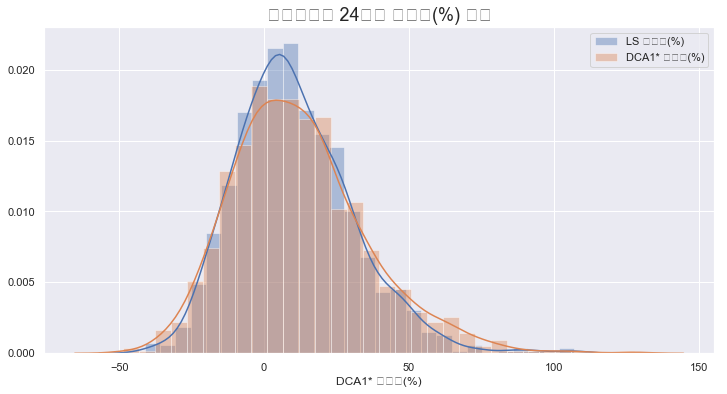

In [18]:
import seaborn as sns

plt.figure(figsize = (12,6))

for x in ['LS 수익률(%)', 'DCA1* 수익률(%)']:
    sns.distplot(result_df[x], label = x)
plt.legend(loc = 'best')
plt.title('부스트래핑 %s개월 수익률(%s) 분포'%(n_period, '%'), fontsize = 18)

describe = result_df[['LS 수익률(%)', 'DCA1* 수익률(%)']].describe().T
describe['왜도'] = result_df[['LS 수익률(%)', 'DCA1* 수익률(%)']].skew(axis = 0)
describe['첨도'] = result_df[['LS 수익률(%)', 'DCA1* 수익률(%)']].kurtosis(axis = 0)
describe = describe.apply(lambda x: round(x,2))

In [20]:
describe

,count,mean,std,min,25%,50%,75%,max,왜도,첨도
LS 수익률(%),1000.0,10.44,20.33,-41.19,-3.76,8.00,22.77,107.11,0.75,1.38
DCA1* 수익률(%),1000.0,12.07,23.44,-48.51,-3.95,9.61,24.45,127.93,0.75,1.16


# Summary_df 

In [26]:
def summarize_by_senario(df, Total = True, **kwargs):
    main_senario_list = ['강', '보', '약']

    column_list = ['메인 시나리오', '세부 시나리오', 'N', 
                   'P_0', 'P_T','H_DCA1', 'H_DCA1*',
                   
                   'DCA1 > LS', 'DCA1 > BH', 
                   'DCA1* > LS', 'DCA1* > BH',

                   'H_DCA1 < P_T', 'H_DCA1* < P_T',

                   'LS 수익률(%)','BH 수익률(%)', 'DCA1 수익률(%)' , 'DCA1* 수익률(%)',
                   'LS 표준편차(%)', 'BH 표준편차(%)', 'DCA1 표준편차(%)', 'DCA1* 표준편차(%)' ,]
    
    for column in ['LS','BH','DCA1','DCA1*']:
        
        column_list.append(column + ' 왜도')
        column_list.append(column + ' 첨도')
        
        for name in [' min',' 1Q',' median', ' 3Q',' max']:
            column_list.append(column+name)
            
    
    
    
    
    store_dict = OrderedDict(\
                             dict((key , []) for key in column_list))

    # 결과 저장 DataFrame

    # 시나리오 기록
    
    if Total == True :
        store_dict['메인 시나리오'].append('전체')
        store_dict['세부 시나리오'].append('전체')
    
    elif Total == False:
        store_dict['메인 시나리오'].append(kwargs['main'])
        store_dict['세부 시나리오'].append(kwargs['sebu'])
    

    # N
    store_dict['N'].append(len(df))



    ################### # P_0 ,P_T , H_DCA1 , H_DCA1 ########################
    for column in ['P_0', 'P_T' , 'H_DCA1', 'H_DCA1*']:
        store_dict[column].append(df[column].mean())


    
    ################# [DCA 1*. DCA 2*] > [LS수익률(%), BH수익률(%)]######################
    for column in ['DCA1','DCA1*']:
        suik_column = column + ' 수익률(%)'

        DCA_win_LS_rate = np.sum(df['%s'%suik_column] > df['LS 수익률(%)']) / len(df)
        DCA_win_BH_rate = np.sum(df['%s'%suik_column] > df['BH 수익률(%)']) / len(df)

        store_dict['%s > LS'%column].append(DCA_win_LS_rate)
        store_dict['%s > BH'%column].append(DCA_win_BH_rate)




    ############### DCA1 , DCA1*, DCA2, DCA2*   > 0 (수익이 난 비율) #######################
    store_dict['H_DCA1 < P_T'].append(np.sum(df['H_DCA1'] < df['P_T']) / len(df))
    store_dict['H_DCA1* < P_T'].append( np.sum(df['H_DCA1*'] < df['P_T']) / len(df))


    #################### # LS, DCA , DCA1 수익률 기록 #######################################

    for column in ['LS', 'BH', 'DCA1', 'DCA1*']:
        
        #### 수익률 ####
        suik_column = column + ' 수익률(%)'
        store_dict[suik_column].append(df[suik_column].mean())
        
        #### 표준편차 ####
        std_column = column + ' 표준편차(%)'
        store_dict[std_column].append(df[suik_column].std())
        
        
        #### 분위수 계산 ####
        for cnt, name in enumerate([' min',' 1Q',' median',' 3Q',' max']):
            quartile = 25 * cnt # 0, 25, 50, 75, 100
            
            store_dict[column + name].append(np.percentile(a= df[suik_column], q=quartile))
        
        #### 왜도 첨도 계산 ####
        store_dict[column + ' 왜도'].append(df[suik_column].skew(axis = 0))
        store_dict[column + ' 첨도'].append(df[suik_column].kurtosis(axis = 0))
    
    
    return_df = DataFrame(store_dict)
    return return_df


In [27]:
for n_period in [12,24,36]:
    
    df_DCA = boostrapping_main_func(n_period = n_period, n_iter = 1000)
    df_DCA.T.to_csv('모든 시나리오 %s개월 (부스트래핑 1개월씩).csv'%n_period)
    
    # 전체 요약
    summary_df = summarize_by_senario(df_DCA)

    # 세부 시나리오별 요약
    for main_senario in ['강','약']:
        temp = df_DCA[df_DCA['메인 시나리오'] == main_senario]

        # 강 보 합, 메인 시나리오 결과 총합
        main_summary_df = summarize_by_senario(temp, Total = False, main = main_senario, sebu = '전체')
        summary_df = pd.concat([summary_df, main_summary_df], axis=0, copy = False)
        sebu_senario_list = sorted(temp['세부 시나리오'].unique())

        for sebu_senario in sebu_senario_list:
            temp2 = temp[temp['세부 시나리오'] == sebu_senario]

            sebu_summary_df = summarize_by_senario(temp2, Total=False, main = main_senario, sebu = sebu_senario)
            summary_df = pd.concat([summary_df , sebu_summary_df], axis=0, copy = False)


    summary_df.set_index('메인 시나리오', inplace= True)
    summary_df.T.to_csv('시나리오별 통계_%s개월 (부스트래핑 1개월씩).csv'%n_period)

0번 반복 완료
500번 반복 완료
0번 반복 완료
500번 반복 완료
0번 반복 완료
500번 반복 완료
